# Univariate Time Series Model of Wind Generation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from datetime import datetime, timedelta

%matplotlib inline
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

import warnings
warnings.simplefilter(action="ignore")

In [2]:
df = pd.read_csv('../../data/final_dfs/combined_final.csv')
temp_df = pd.read_csv('../../data/texas_temp.csv')

In [3]:
df.head()

,date,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas
0,2011-01-01,1240.848016,304483.8981,670.712237,90516.91023,357.449324,70.651290,123213.38820,248086.36399
1,2011-01-02,1478.590690,320703.6726,667.009668,90462.21494,372.626928,10.255158,62531.39844,268971.64998
2,2011-01-03,1483.246127,296436.2237,741.426017,90472.37075,401.536782,15.155827,89515.57352,222285.00985
3,2011-01-04,1411.010006,322214.6377,683.281626,90312.68708,478.415477,5.278214,59542.48570,271747.93685
4,2011-01-05,1348.331266,308136.0801,623.145421,90280.19160,440.383112,22.997359,128920.84250,358001.80005


In [4]:
temp_df.head()

,Date,Temp
0,1/1/11,45.0
1,2/1/11,48.7
2,3/1/11,61.8
3,4/1/11,70.3
4,5/1/11,74.1


In [5]:
df = df[['date', 'Coal']]

In [6]:
df['date']=pd.to_datetime(df['date'])

In [7]:
df = df[df['date'].dt.day == 1]

In [8]:
df.reset_index(inplace=True)

In [9]:
df.drop(columns='index',inplace=True)

In [10]:
df_full = pd.concat([df, temp_df], axis =1)

In [11]:
df_full

,date,Coal,Date,Temp
0,2011-01-01,304483.898100,1/1/11,45.0
1,2011-02-01,279062.124100,2/1/11,48.7
2,2011-03-01,320169.090800,3/1/11,61.8
3,2011-04-01,302825.068800,4/1/11,70.3
4,2011-05-01,377862.065400,5/1/11,74.1
...,...,...,...,...
115,2020-08-01,205519.272374,8/1/20,84.3
116,2020-09-01,302849.322593,9/1/20,74.0
117,2020-10-01,189856.306290,10/1/20,65.9
118,2020-11-01,193136.311647,11/1/20,60.6


In [12]:
train_dates = pd.to_datetime(df['date'])
df_full.drop(columns='Date',inplace=True)
#df_full.set_index('date', inplace=True)

In [13]:
df_full

,date,Coal,Temp
0,2011-01-01,304483.898100,45.0
1,2011-02-01,279062.124100,48.7
2,2011-03-01,320169.090800,61.8
3,2011-04-01,302825.068800,70.3
4,2011-05-01,377862.065400,74.1
...,...,...,...
115,2020-08-01,205519.272374,84.3
116,2020-09-01,302849.322593,74.0
117,2020-10-01,189856.306290,65.9
118,2020-11-01,193136.311647,60.6


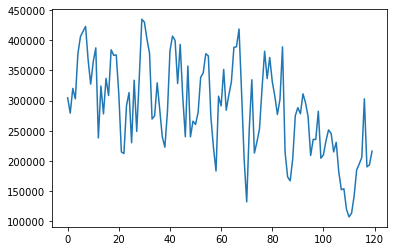

In [15]:
plt.plot(df_full['Coal'])

### Because Natural Gas and Temperautre are on such different scales, let's apply a standard scaler

In [16]:
cols = list(df_full)[1:3]

In [18]:
df_train = df_full[cols].astype(float)

In [19]:
sc = StandardScaler()
sc = sc.fit(df_train)
df_sc = sc.transform(df_train)

### Create our train and prediction series

In [20]:
trainX = []
trainY = []

n_future = 1
n_past = 14

for i in range(n_past, len(df_sc) - n_future +1):
    trainX.append(df_sc[i - n_past:i, 0:df_train.shape[1]])
    trainY.append(df_sc[i + n_future - 1:i + n_future, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (106, 14, 2).
trainY shape == (106, 1).


### Instantiate and Fit our Model

In [21]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17152     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________


In [22]:
history= model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
6/6 [==============================] - 3s 87ms/step - loss: 0.8335 - val_loss: 2.1577
Epoch 2/10
6/6 [==============================] - 0s 19ms/step - loss: 0.7455 - val_loss: 1.9021
Epoch 3/10
6/6 [==============================] - 0s 19ms/step - loss: 0.7819 - val_loss: 1.7161
Epoch 4/10
6/6 [==============================] - 0s 24ms/step - loss: 0.7014 - val_loss: 1.4748
Epoch 5/10
6/6 [==============================] - 0s 22ms/step - loss: 0.8607 - val_loss: 1.1070
Epoch 6/10
6/6 [==============================] - 0s 23ms/step - loss: 0.6877 - val_loss: 1.4412
Epoch 7/10
6/6 [==============================] - 0s 20ms/step - loss: 0.5996 - val_loss: 3.5716
Epoch 8/10
6/6 [==============================] - 0s 24ms/step - loss: 0.6330 - val_loss: 14.5607
Epoch 9/10
6/6 [==============================] - 0s 20ms/step - loss: 0.6578 - val_loss: 7.9652
Epoch 10/10
6/6 [==============================] - 0s 20ms/step - loss: 0.4687 - val_loss: 5.7177


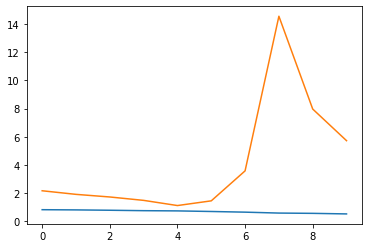

In [23]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

In [24]:
n_forecast = 24
forecast_period_dates = pd.date_range(start=list(train_dates)[-1], periods=n_forecast, freq='MS').tolist()

In [25]:
len(forecast_period_dates)

24

In [26]:
forecast = model.predict(trainX[-n_forecast:])

In [27]:
len(forecast)

24

In [28]:
forecast_copies = np.repeat(forecast, df_train.shape[1], axis=-1)


In [29]:
y_pred_future = sc.inverse_transform(forecast_copies)[:,0]  # Take

In [30]:
len(y_pred_future)

24

In [31]:
len(forecast_copies)

24

In [32]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [39]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Coal':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [40]:
original = pd.DataFrame(df_full[['date', 'Coal']])


In [41]:
original

,date,Coal
0,2011-01-01,304483.898100
1,2011-02-01,279062.124100
2,2011-03-01,320169.090800
3,2011-04-01,302825.068800
4,2011-05-01,377862.065400
...,...,...
115,2020-08-01,205519.272374
116,2020-09-01,302849.322593
117,2020-10-01,189856.306290
118,2020-11-01,193136.311647


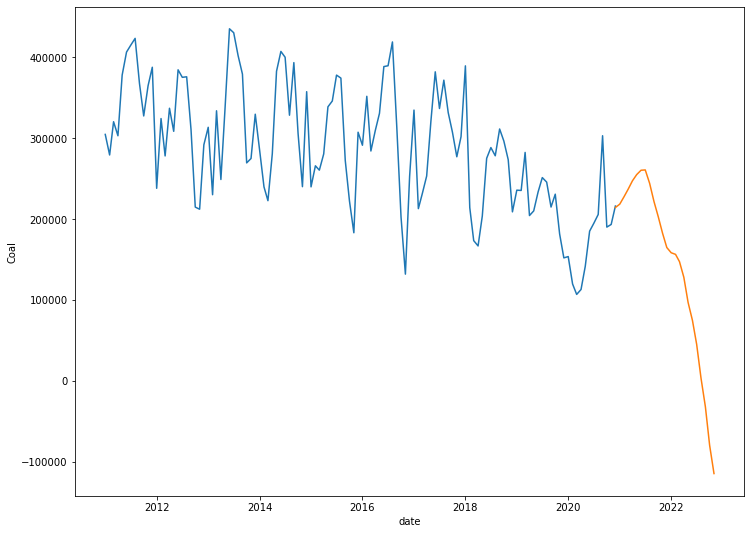

In [42]:
plt.figure(figsize=(12,9))
sns.lineplot(original['date'], original['Coal']);
sns.lineplot(df_forecast['Date'], df_forecast['Coal']);